### About the company: 
- The olist is the ideal solution for those who want to sell professionally and effectively in e-commerce. They help those who want to sell, find those who want to buy, who have thousands of partner retailers and have already sold products to millions of people across Brazil. 
- The company has grown to help more than 12,000 merchants run their businesses with a team of more than 300 Olisters.
- Olist operates an online e-commerce site for sellers, that connects merchants and their products to main marketplaces.
- Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners.
- After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

### About the Dataset:
- This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. 
- Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.
- This is real commercial data, it has been anonymised, and references to the companies and partners in the review text have been replaced with the names of Game of Thrones great houses.
### Attention
1. An order might have multiple items.
2. Each item might be fulfilled by a distinct seller.
3. All text identifying stores and partners where replaced by the names of Game of Thrones great houses.


![Data schema](https://i.imgur.com/HRhd2Y0.png)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
olist_customer = pd.read_csv('/content/drive/MyDrive/Dynamic_Pricing/olist_customers_dataset.csv')
olist_geolocation = pd.read_csv('/content/drive/MyDrive/Dynamic_Pricing/olist_geolocation_dataset.csv')
olist_orders = pd.read_csv('/content/drive/MyDrive/Dynamic_Pricing/olist_orders_dataset.csv')
olist_order_items = pd.read_csv('/content/drive/MyDrive/Dynamic_Pricing/olist_order_items_dataset.csv')
olist_order_payments = pd.read_csv('/content/drive/MyDrive/Dynamic_Pricing/olist_order_payments_dataset.csv')
olist_order_reviews = pd.read_csv('/content/drive/MyDrive/Dynamic_Pricing/olist_order_reviews_dataset.csv')
olist_products = pd.read_csv('/content/drive/MyDrive/Dynamic_Pricing/olist_products_dataset.csv')
olist_sellers = pd.read_csv('/content/drive/MyDrive/Dynamic_Pricing/olist_sellers_dataset.csv')

In [5]:

olist_products_translation = pd.read_csv('/content/drive/MyDrive/Dynamic_Pricing/product_category_name_translation.csv')

In [6]:
datasets = [olist_customer, olist_geolocation, olist_orders, olist_order_items, olist_order_payments,
            olist_order_reviews, olist_products, olist_sellers]
names = ['olist_customer', 'olist_geolocation', 'olist_orders', 'olist_order_items', 'olist_order_payments',
         'olist_order_reviews', 'olist_products', 'olist_sellers']

# Creating a DataFrame with useful information about all datasets
data_info = pd.DataFrame()
data_info['dataset'] = names
data_info['n_rows'] = [df.shape[0] for df in datasets]
data_info['n_cols'] = [df.shape[1] for df in datasets]
data_info['total_null'] = [df.isnull().sum().sum() for df in datasets]
data_info['qty_null_columns'] = [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
data_info['null_columns'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]

data_info.style.background_gradient()

,dataset,n_rows,n_cols,total_null,qty_null_columns,null_columns
0,olist_customer,99441,5,0,0,
1,olist_geolocation,1000163,5,0,0,
2,olist_orders,99441,8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
3,olist_order_items,112650,7,0,0,
4,olist_order_payments,103886,5,0,0,
5,olist_order_reviews,100000,7,146532,2,"review_comment_title, review_comment_message"
6,olist_products,32951,9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,olist_sellers,3095,4,0,0,


### Customers Dataset
- This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset and to find the orders delivery location.
- At our system each order is assigned to a unique customerid. This means that the same customer will get different ids for different orders. The purpose of having a customerunique_id on the dataset is to allow you to identify customers that made repurchases at the store. Otherwise you would find that each order had a different customer associated with.

In [7]:
olist_customer.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [8]:
olist_customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


#### Observations
* There are no null values in the customers dataset
* This Dataset has three object type columns and one numerical type column.

In [9]:
olist_customer.describe(include=np.object)

,customer_id,customer_unique_id,customer_city,customer_state
count,99441,99441,99441,99441
unique,99441,96096,4119,27
top,18e4dd593a3162753b5c6081fb581862,8d50f5eadf50201ccdcedfb9e2ac8455,sao paulo,SP
freq,1,17,15540,41746


#### Observations
* There are 99441 unique customer_ids and each order has unique customer_id.
* Customer_unique_id has a total count of 99441,out of these 96096 are unique and most common customer id is `8d50f5eadf50201ccdcedfb9e2ac8455` with the frequency of 17.
* Customer_city has total count of 99441 and it has 4119 unique cities,most of the purchase occurs at sao paulo with a frequency of 15540,in others words there are more customers are from sao paulo.
* Customer_state has 27 unique states and the state SP tops the list with a frequency of 41746.
##### SP - here stands for Sao paulo state and its understood that its the state for the city sao paulo.
##### São Paulo is the richest and most populous state of Brazil, ranking 16th and 27th worldwide, respectively. It is the foremost industrial centre in Latin America. No wonder, most of the purchases are from this state. Rio de janeiro be the second richest in the country.

### Univariate Analysis
#### Feature-1 customer_id  

In [10]:
olist_customer['customer_id'].nunique()

99441

Each order is assigned to a unique customer_id. The means that the same customer will get different ids for different orders

#### Feature-2 customer_unique_id

In [11]:
olist_customer['customer_unique_id'].value_counts()[olist_customer['customer_unique_id'].value_counts() == 1].value_counts()

1    93099
Name: customer_unique_id, dtype: int64

In [12]:
olist_customer['customer_unique_id'].nunique() - 93099

2997

In [13]:
olist_customer['customer_unique_id'].value_counts().head(2997)

8d50f5eadf50201ccdcedfb9e2ac8455    17
3e43e6105506432c953e165fb2acf44c     9
1b6c7548a2a1f9037c1fd3ddfed95f33     7
ca77025e7201e3b30c44b472ff346268     7
6469f99c1f9dfae7733b25662e7f1782     7
                                    ..
e2889baccec81ed3bed4d66c1c675cb2     2
740b9a28b39035534bf3425b19016263     2
cabef558b42bd1d2578afc81048e8415     2
f06d35a600b606329886d392afda66c7     2
eac6dbc8ecd0a2f08ed8e53d18f0e0d0     2
Name: customer_unique_id, Length: 2997, dtype: int64

In [14]:
olist_customer['customer_unique_id'].value_counts()[olist_customer['customer_unique_id'].value_counts() > 10].value_counts()

17    1
Name: customer_unique_id, dtype: int64

In [15]:
olist_customer['customer_unique_id'].value_counts()[olist_customer['customer_unique_id'].value_counts() > 5].value_counts()

6     6
7     3
9     1
17    1
Name: customer_unique_id, dtype: int64

In [16]:
olist_customer['customer_unique_id'].value_counts()[olist_customer['customer_unique_id'].value_counts() == 2].value_counts()

2    2745
Name: customer_unique_id, dtype: int64

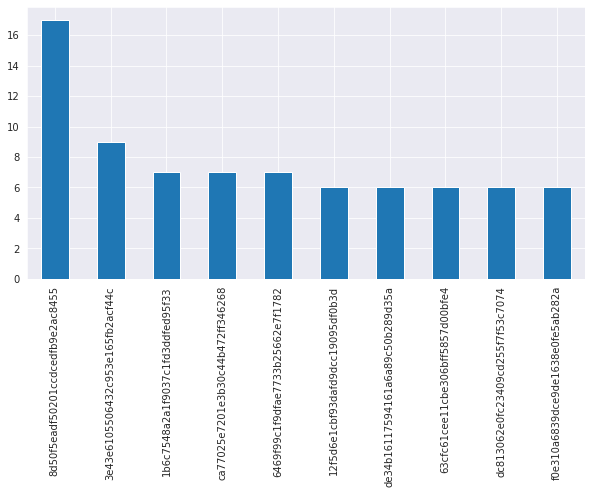

In [17]:
## selecting top 10
plt.figure(figsize=(10,5))
olist_customer['customer_unique_id'].value_counts().head(10).plot(kind='bar')
plt.show()

#### Observations
* The purchase frequency of top 10 customers in the year 2016 to 2018 ranges from 17 to 6.
* There are only 2997 customers who shopped more than once.
* There are 93099 one time shoppers.
* Only 1 shopper has purchased more than 10 times.
* There are 11 shoppers who purchased more than 5 times.
* There are 2745 customers who purchased only twice.

#### Feature-3 customer-city

In [18]:
olist_customer['customer_city'].value_counts()

sao paulo            15540
rio de janeiro        6882
belo horizonte        2773
brasilia              2131
curitiba              1521
                     ...  
canto do buriti          1
jaquirana                1
buriti alegre            1
sao jose do piaui        1
urucuia                  1
Name: customer_city, Length: 4119, dtype: int64

In [20]:
olist_customer['customer_city'].value_counts()[olist_customer['customer_city'].value_counts() == 1].count()

1144

In [21]:
4119 - 1144

2975

In [22]:
olist_customer['customer_city'].value_counts().head(2975)

sao paulo         15540
rio de janeiro     6882
belo horizonte     2773
brasilia           2131
curitiba           1521
                  ...  
iacri                 2
avelino lopes         2
itatiaiucu            2
vargem                2
getulina              2
Name: customer_city, Length: 2975, dtype: int64

In [23]:
olist_customer['customer_city'].nunique()

4119

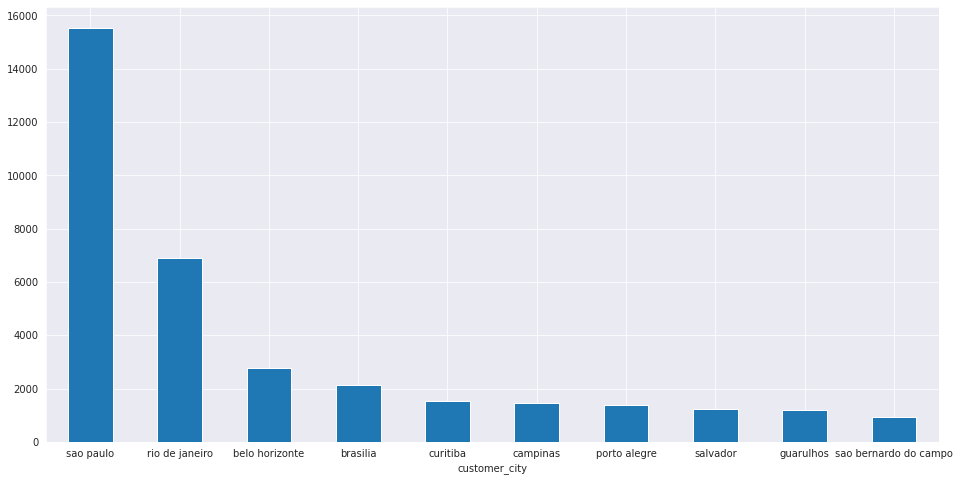

In [24]:
c = olist_customer.groupby('customer_city')['customer_id'].nunique().sort_values(ascending=False)
c1 = c.head(10)
plt.figure(figsize=(16,8))
c1.plot(kind='bar',rot=0)
plt.show()

In [25]:
## Total customers from the top 10 cities
c1.sum()

35042

In [26]:
print('Top 10 cities covers',round(c1.sum()/olist_customer.shape[0]*100,1),'percentage of all the orders')

Top 10 cities covers 35.2 percentage of all the orders


#### Observations
* Sao paulo,rio de janeiro and belo horizonte are the top 3 cities which has more customers.
* A total of 35042 customers are from the top 10 shopping cities.
* There are 1144 cities where shopping is done only once.
* Top 10 cities covers 35.2 percentage of all the orders

#### Feature-4 customer-state

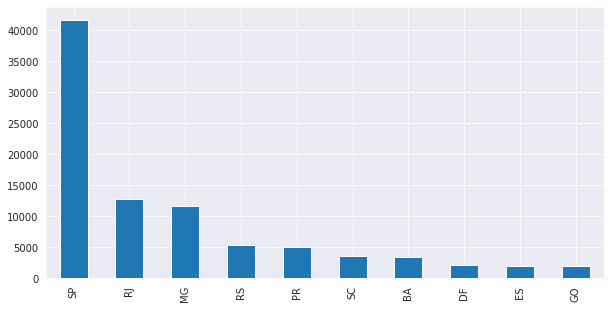

In [27]:
## Top-10 customer states
plt.figure(figsize=(10,5))
olist_customer['customer_state'].value_counts().head(10).plot(kind='bar')
plt.show()

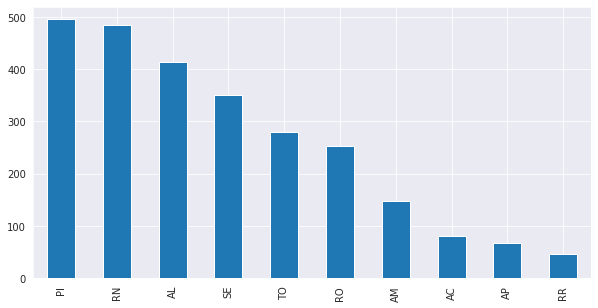

In [28]:
## Bottom-10 customer states
plt.figure(figsize=(10,5))
olist_customer['customer_state'].value_counts().tail(10).plot(kind='bar')
plt.show()

#### Observations
* More customers shop from the states SP, RJ, MG, whereas the number of shoppers from AC, AP, RR are the least.

In [29]:
## customer_zipcode
olist_customer['customer_zip_code_prefix'].value_counts()

22790    142
24220    124
22793    121
24230    117
22775    110
        ... 
59820      1
47590      1
56313      1
44023      1
39113      1
Name: customer_zip_code_prefix, Length: 14994, dtype: int64

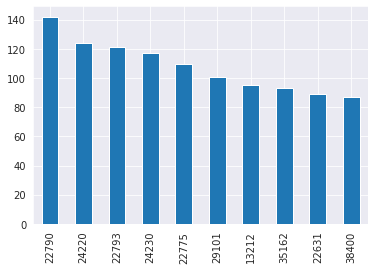

In [30]:
olist_customer['customer_zip_code_prefix'].value_counts().head(10).plot(kind='bar')
plt.show()

In [31]:
zips = olist_customer.groupby('customer_zip_code_prefix')['customer_id'].nunique().sort_values(ascending=False)
print("Products were delivered the most frequently,",zips.iloc[0],"times, to the", zips.index[0], "zip code.")

Products were delivered the most frequently, 142 times, to the 22790 zip code.


Merging 

In [32]:
## Joining orders, payments and customers,items,products,category
ord_pay = pd.merge(olist_orders,olist_order_payments,on='order_id')
ord_pay = ord_pay.merge(olist_customer,on='customer_id')
ord_pay = ord_pay.merge(olist_order_items,on='order_id')
ord_pay = ord_pay.merge(olist_products,on='product_id')
ord_pay = ord_pay.merge(olist_products_translation,on='product_category_name')
ord_pay = ord_pay.merge(olist_sellers,on='seller_id')

In [33]:
pd.set_option('display.max_columns',None)
ord_pay.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP


In [34]:
ord_pay.drop(columns='product_category_name',inplace=True)

In [35]:
## checking for missing values
missing = ord_pay.isnull().sum()/ord_pay.shape[0] * 100
missing[missing > 0]

order_approved_at                0.012082
order_delivered_carrier_date     1.039887
order_delivered_customer_date    2.153127
product_weight_g                 0.000863
product_length_cm                0.000863
product_height_cm                0.000863
product_width_cm                 0.000863
dtype: float64

## Observations
* There are some missing values in the dataset and has less than 3 percentage.

In [36]:
ord_pay['order_purchase_timestamp'] = pd.to_datetime(ord_pay['order_purchase_timestamp'])
ord_pay['order_approved_at'] = pd.to_datetime(ord_pay['order_approved_at'])
ord_pay['order_delivered_carrier_date'] = pd.to_datetime(ord_pay['order_delivered_carrier_date'])
ord_pay['order_delivered_customer_date'] = pd.to_datetime(ord_pay['order_delivered_customer_date'])
ord_pay['order_estimated_delivery_date'] = pd.to_datetime(ord_pay['order_estimated_delivery_date'])

In [37]:
subset = list(olist_orders.columns)
subset_1 = ord_pay[subset]

In [38]:
subset_1['order_status'].value_counts()

delivered      113384
shipped          1214
canceled          549
processing        362
invoiced          359
unavailable         7
approved            3
Name: order_status, dtype: int64

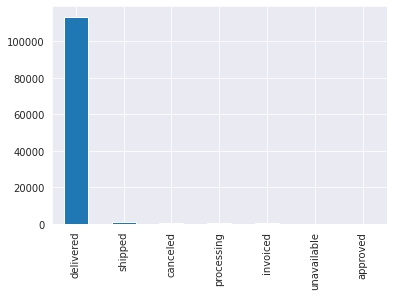

In [39]:
subset_1['order_status'].value_counts().plot(kind='bar')
plt.show()

### Observations
* It seems that most of the orders have been delivered.

In [40]:
## How many purchases were made in year,month and day
subset_1.insert(loc=3,column='purchase_year',value=subset_1.order_purchase_timestamp.dt.year)
subset_1.insert(loc=4,column='purchase_month',value=subset_1.order_purchase_timestamp.dt.month_name())
subset_1.insert(loc=5,column='purchase_day',value=subset_1.order_purchase_timestamp.dt.day)

In [41]:
subset_1['purchase_year'].value_counts()

2018    62938
2017    52557
2016      383
Name: purchase_year, dtype: int64

In [42]:
subset_1.head()

,order_id,customer_id,order_status,purchase_year,purchase_month,purchase_day,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017,October,2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017,October,2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017,October,2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017,August,15,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017,August,2,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15


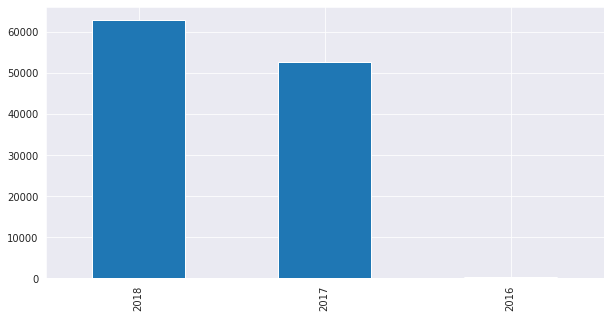

In [43]:
plt.figure(figsize=(10,5))
a = subset_1['purchase_year'].value_counts()
a.plot(kind='bar')
plt.show()

## Observations
* The purchases are way more high in the year 2018 compared to rest of the years.
* A total count of 62938 purchases were made in the year 2018 and 52557 purchases in the year 2017.
* It is interesting to see that only 383 purchases were made in the year 2016 and the next two consecutive years the         purchases increased dramastically.
* With this information we can cleary see that E-commerce market in brazil is growing.

In [44]:
## Month-wise purchases
subset_1['purchase_month'].value_counts()

August       12513
May          12458
July         12038
March        11520
June         11082
April        10956
February      9800
January       9316
November      8883
December      6415
October       5874
September     5023
Name: purchase_month, dtype: int64

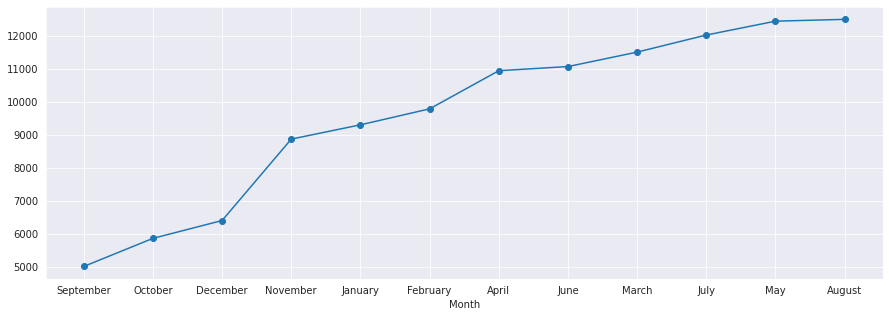

In [45]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,5))
month_wise = subset_1['purchase_month'].value_counts().sort_values(ascending=True)
plt.plot(month_wise.index,month_wise.values,marker='o')
plt.xlabel('Month')
plt.show()

## Observations
* August,May,July and March have more purchases and it is also interesting to see that november and december don't have
  many purchases despite of the black friday sales and christmas holidays.
* It is also possible they might have some festivals in the other months.

##### Estiamating the Lead Time
* Lead Time is basically time between placing an order and receiving it

In [46]:
import warnings
warnings.filterwarnings("ignore")

subset_1['lead'] = (subset_1['order_delivered_customer_date'] - subset_1['order_purchase_timestamp']).dt.days
subset_1.head(3)

,order_id,customer_id,order_status,purchase_year,purchase_month,purchase_day,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,lead
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017,October,2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017,October,2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017,October,2,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.0


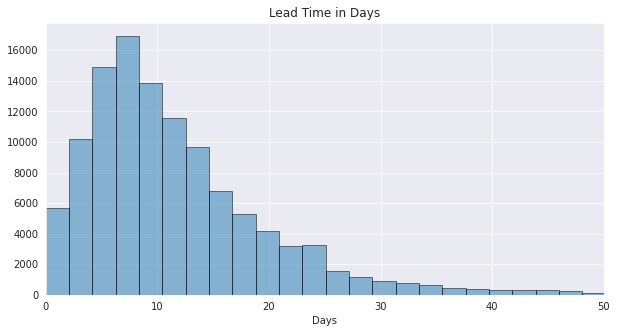

In [47]:
plt.figure(figsize=(10,5))
plt.hist(subset_1['lead'],bins=100,alpha=0.5,edgecolor='black')
plt.title('Lead Time in Days')
plt.xlabel('Days')
plt.xlim((0,50))
plt.show()

#### Observations
* From the above plot we can infer that 50% of the orders get delivered within 10 days 
  which is a good sign for the business.
* Few orders takes more than 20 days to deliver to the customer.

**Back order rate**

The Backorder Rate KPI measures how many orders cannot be filled at the time a customer places them. This is measured by frequency of orders delivered later than the  the estimated delivery date.

In [187]:
subset_1['back_order'] = (subset_1['order_delivered_customer_date'] - subset_1['order_estimated_delivery_date']).dt.days
back_order_rate = subset_1[subset_1['back_order'] > 0]

In [192]:
back_order_rate.head(3)

,order_id,customer_id,order_status,purchase_year,purchase_month,purchase_day,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,lead,back_order
58,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017,November,24,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,33.0,7.0
75,d2ce7421730f81ac57551e623ed3522d,873967bfecc663740e5d43930cc64b7b,delivered,2017,April,25,2017-04-25 16:48:35,2017-04-25 16:55:23,2017-04-27 10:00:13,2017-05-17 10:18:51,2017-05-16,21.0,1.0
111,c49be9a11fd13933307cc6a19b03a895,a972623b3481cbfd95fa776b0067e554,delivered,2018,May,15,2018-05-15 18:54:39,2018-05-17 03:16:13,2018-05-17 13:51:00,2018-06-06 13:27:44,2018-05-30,21.0,7.0


In [208]:
orders_delayed = back_order_rate.order_id.nunique()
total_number_of_customers_orders_shipped = ord_pay.order_status.value_counts()[0]

In [210]:
back_order = orders_delayed/total_number_of_customers_orders_shipped * 100
back_order

5.678049813024765

Observations
* Furniture is one of the product category prone to have high lead time. This is mainly because sellers aren’t able to fulfill the orders right time. Knowing furniture may comparably longer manufacturing time, perhaps better forecasting strategy is required by the sellers

* Nearly 5.68% of the products went on backorder

In [48]:
ord_pay['lead'] = (ord_pay['order_delivered_customer_date'] - ord_pay['order_purchase_timestamp']).dt.days

In [49]:
## lets see which product category takes more than 20 days to deliver
cat = ord_pay[ord_pay['lead'] > 20]
cat.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,lead
7,1fa40f202d5d233b6491e976c557b822,50fd5707c28d0a64dc20d67f937dd9ba,delivered,2017-09-23 22:11:10,2017-09-23 22:25:11,2017-09-26 17:27:54,2017-10-19 21:09:21,2017-11-13,1,credit_card,1,50.05,35c6ec4630637b3ec0da6e587f245f83,69043,manaus,AM,1,8415b1dae10d2dcb36beec370c6a90cd,3504c0cb71d7fa48d967e0e4c94d59d9,2017-09-27 22:25:11,28.9,21.15,59.0,322.0,5.0,600.0,24.0,5.0,18.0,housewares,9350,maua,SP,25.0
58,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,delivered,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-13 21:14:05,2017-12-28 18:59:23,2017-12-21,1,credit_card,10,356.12,3e4fd73f1e86b135b9b121d6abbe9597,19400,presidente venceslau,SP,1,be021417a6acb56b9b50d3fd2714baa8,f5f46307a4d15880ca14fab4ad9dfc9b,2017-11-30 00:21:09,339.0,17.12,48.0,664.0,6.0,14300.0,38.0,34.0,34.0,housewares,89165,rio do sul,SC,33.0
75,d2ce7421730f81ac57551e623ed3522d,873967bfecc663740e5d43930cc64b7b,delivered,2017-04-25 16:48:35,2017-04-25 16:55:23,2017-04-27 10:00:13,2017-05-17 10:18:51,2017-05-16,1,credit_card,2,53.11,14e45ce4cfe711aa6d32e974517bc76b,88010,florianopolis,SC,1,a5a0e71a81ae65aa335e71c06261e260,c8417879a15366a17c30af34c798c332,2017-05-02 16:55:23,38.0,15.11,57.0,698.0,3.0,705.0,34.0,22.0,28.0,housewares,4445,sao paulo,SP,21.0


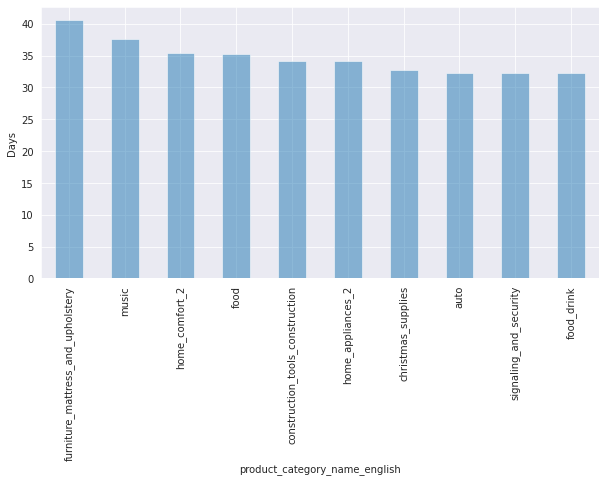

In [50]:
##average lead time
plt.figure(figsize=(10,5))
a = cat.groupby('product_category_name_english')['lead'].mean()
a.sort_values(ascending=False).head(10).plot(kind='bar',alpha=0.5)
plt.ylabel('Days')
plt.show()

In [51]:
##payments
olist_order_payments.head(3)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71


In [52]:
olist_order_payments['payment_type'].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

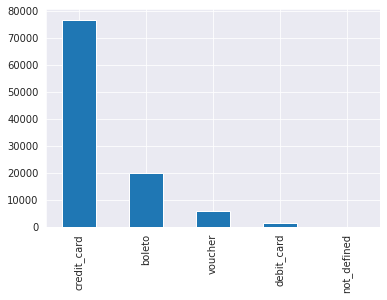

In [53]:
olist_order_payments['payment_type'].value_counts().plot(kind='bar')
plt.show()

In [54]:
a = olist_order_payments['payment_type'].value_counts().sum()
b = olist_order_payments['payment_type'].value_counts()/a * 100
b

credit_card    73.922376
boleto         19.043952
voucher         5.558978
debit_card      1.471806
not_defined     0.002888
Name: payment_type, dtype: float64

## Observations
* Nearly 74% of the payments have been done by credit_card and boleto has 20% of the payments.

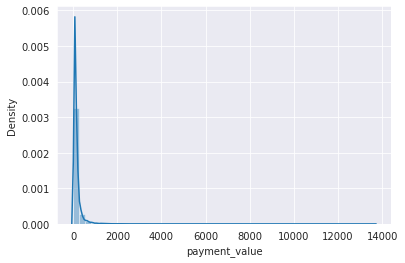

In [55]:
sns.distplot(olist_order_payments['payment_value'])
plt.show()

In [56]:
##Top-five payment_sequential
olist_order_payments['payment_sequential'].value_counts().nlargest()

1    99360
2     3039
3      581
4      278
5      170
Name: payment_sequential, dtype: int64

In [57]:
a = olist_order_payments['payment_sequential'].value_counts().nlargest()/olist_order_payments['payment_sequential'].value_counts().sum() * 100
a

1    95.643301
2     2.925322
3     0.559267
4     0.267601
5     0.163641
Name: payment_sequential, dtype: float64

## Observations
* A customer may pay an order with more than one payment method. if the customer does so, sequence will be created.
* Nearly 95.64 % of the customers are paying by only one method.

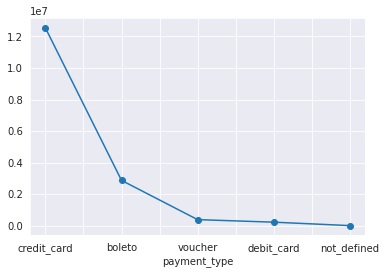

In [58]:
##How much total amount of money has been paid by customers using different payment methods
olist_order_payments.groupby('payment_type')['payment_value'].sum().nlargest().plot(kind='line',marker='o')
plt.show()

In [59]:
##order_id vs payment
olist_order_payments.groupby('order_id')['payment_value'].sum().nlargest()

order_id
03caa2c082116e1d31e67e9ae3700499    13664.08
736e1922ae60d0d6a89247b851902527     7274.88
0812eb902a67711a1cb742b3cdaa65ae     6929.31
fefacc66af859508bf1a7934eab1e97f     6922.21
f5136e38d1a14a4dbd87dff67da82701     6726.66
Name: payment_value, dtype: float64

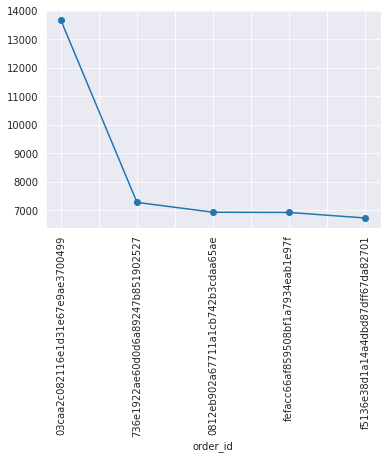

In [60]:
olist_order_payments.groupby('order_id')['payment_value'].sum().nlargest().plot(kind='line',marker="o")
plt.xticks(rotation=90)
plt.show()

In [61]:
##products
a = list(olist_products.columns)
a[1] = 'product_category_name_english'
product = ord_pay[a]

In [62]:
product.head(3)

,product_id,product_category_name_english,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,87285b34884572647811a353c7ac498a,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
1,87285b34884572647811a353c7ac498a,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0
2,87285b34884572647811a353c7ac498a,housewares,40.0,268.0,4.0,500.0,19.0,8.0,13.0


In [63]:
product.describe()

,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,115878.000000,115878.000000,115878.000000,115877.000000,115877.000000,115877.000000,115877.000000
mean,48.766116,786.956428,2.207727,2117.594190,30.311554,16.656886,23.110445
std,10.035366,653.071898,1.719519,3785.744297,16.225837,13.480721,11.758209
min,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000
25%,42.000000,347.000000,1.000000,300.000000,18.000000,8.000000,15.000000
50%,52.000000,601.000000,1.000000,700.000000,25.000000,13.000000,20.000000
75%,57.000000,985.000000,3.000000,1800.000000,38.000000,20.000000,30.000000
max,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000


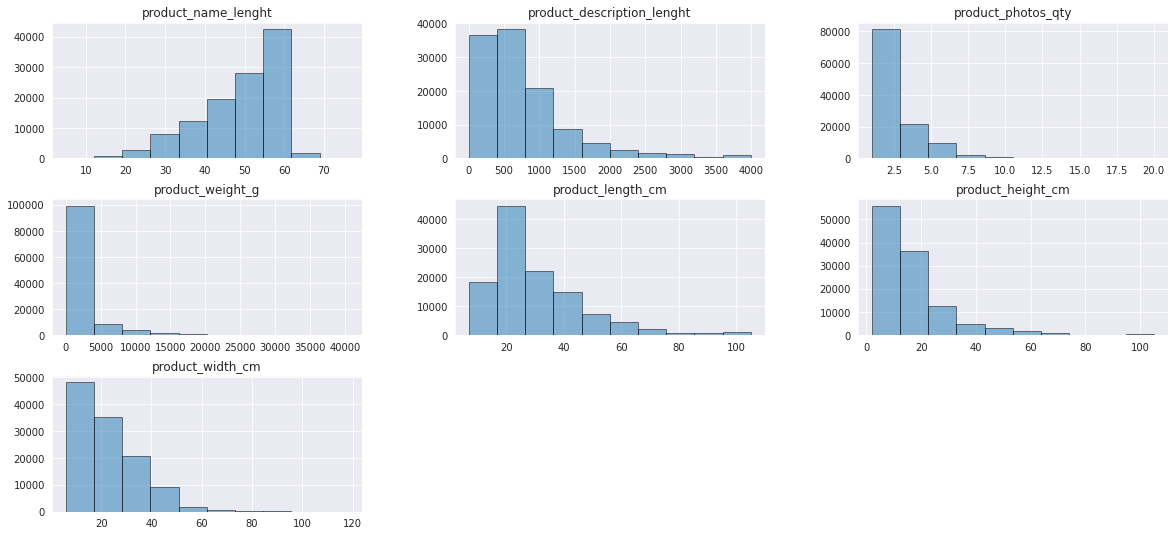

In [64]:
product.hist(figsize=(20,9),alpha=0.5,edgecolor='black')
plt.show()

## Observations
* From the above histograms we can infer that the distributions of product_weight,product_length,product_height,product_width are right-skewed.
* Product_name,description,photos are not that much useful in predicting the price.

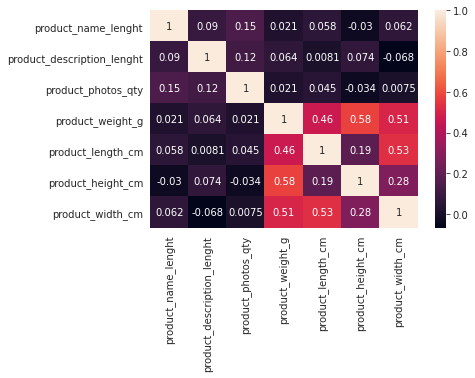

In [65]:
a = product.select_dtypes(exclude=np.object)
sns.heatmap(a.corr(),annot=True)
plt.show()


In [66]:
##sellers
olist_sellers.head(3)

,seller_id,seller_zip_code_prefix,seller_city,seller_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP
1,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP
2,ce3ad9de960102d0677a81f5d0bb7b2d,20031,rio de janeiro,RJ


In [67]:
c = olist_sellers['seller_id'].nunique()
print('There are {} unique sellers'.format(c))

There are 3095 unique sellers


In [68]:
##seller_zip_code_prefix
d = olist_sellers['seller_zip_code_prefix'].nunique()
print('There are {} unique seller_zip_code'.format(d))

There are 2246 unique seller_zip_code


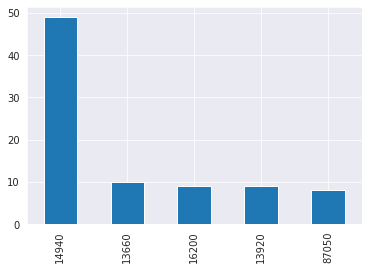

In [69]:
olist_sellers['seller_zip_code_prefix'].value_counts().nlargest().plot(kind='bar')
plt.show()

In [70]:
zips = olist_sellers.groupby('seller_zip_code_prefix')['seller_id'].nunique().sort_values(ascending=False)
print("Products were sold most frequently,",zips.iloc[0],"times, from the", zips.index[0], "zip code.")

Products were sold most frequently, 49 times, from the 14940 zip code.


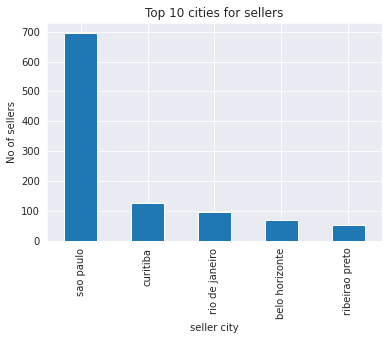

In [71]:
z = olist_sellers['seller_city'].value_counts().nlargest()
z.plot(kind='bar')
plt.title('Top 10 cities for sellers')
plt.xlabel('seller city')
plt.ylabel('No of sellers')
plt.show()


In [72]:
olist_sellers['seller_city'].value_counts().nlargest()/olist_sellers['seller_city'].value_counts().nlargest().sum() * 100

sao paulo         66.923819
curitiba          12.246866
rio de janeiro     9.257473
belo horizonte     6.557377
ribeirao preto     5.014465
Name: seller_city, dtype: float64

## Observations
* Nearly 67% of sellers are from sao paulo because the customers are also more in Sao paulo,we can also say majority of the business happens in the sao paulo region.
* curitiba holds 12.24 % sellers and rio de janeiro hols 9.25 % sellers.

In [73]:
olist_sellers['seller_state'].value_counts().nlargest()

SP    1849
PR     349
MG     244
SC     190
RJ     171
Name: seller_state, dtype: int64

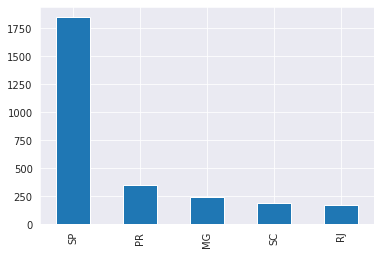

In [74]:
## Top 5 states for sellers
olist_sellers['seller_state'].value_counts().nlargest().plot(kind='bar')
plt.show()

In [75]:
## Bottom 5 states for sellers
olist_sellers['seller_state'].value_counts().nsmallest()

PA    1
PI    1
MA    1
AM    1
AC    1
Name: seller_state, dtype: int64

In [76]:
ord_pay.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state,lead
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP,8.0
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP,8.0
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,40.0,268.0,4.0,500.0,19.0,8.0,13.0,housewares,9350,maua,SP,8.0


In [77]:
##items
olist_order_items.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0,17.87


In [78]:
olist_order_items['order_id'].value_counts()

8272b63d03f5f79c56e9e4120aec44ef    21
ab14fdcfbe524636d65ee38360e22ce8    20
1b15974a0141d54e36626dca3fdc731a    20
428a2f660dc84138d969ccd69a0ab6d5    15
9ef13efd6949e4573a18964dd1bbe7f5    15
                                    ..
d1f3aacf6953cd2cb98b26b17fa5ba14     1
cb2b577a4ebd84bf84ff3990084d490f     1
3f0d61c44dd01ad249fa7589cbdcb8b3     1
31387068a4e9c19d93f6e8b13853bc46     1
8426a61c687c38a2fb35080413ec9eb4     1
Name: order_id, Length: 98666, dtype: int64

In [79]:
olist_order_items['product_id'].value_counts()

aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
                                   ... 
5cebe3c91f03e5d52a1951b3ce8354cd      1
06ae026e430189633c2fbd0288c86257      1
496e7805727644d3146f931ff28552f3      1
67f1a036affe9a75b73dfddf0386893a      1
f54cd09fa7e3c0f502187f200eb84084      1
Name: product_id, Length: 32951, dtype: int64

In [80]:
olist_order_items['seller_id'].value_counts()

6560211a19b47992c3666cc44a7e94c0    2033
4a3ca9315b744ce9f8e9374361493884    1987
1f50f920176fa81dab994f9023523100    1931
cc419e0650a3c5ba77189a1882b7556a    1775
da8622b14eb17ae2831f4ac5b9dab84a    1551
                                    ... 
ebe3dabc4955c9b0d695e7bda38bf5c3       1
19a7c9f66ffa6452ff4b4c0cca71da27       1
babcc0ab201e4c60188427cae51a5b8b       1
ede2977fbaf3738583170735ca403f6c       1
19484c79cef6c062cb177aa4ef2fcc3c       1
Name: seller_id, Length: 3095, dtype: int64

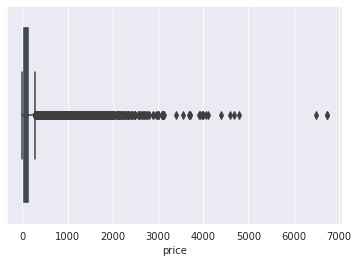

In [81]:
sns.boxplot(olist_order_items['price'])
plt.show()

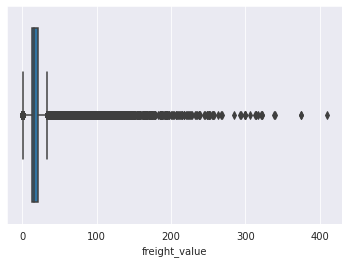

In [82]:
sns.boxplot(olist_order_items['freight_value'])
plt.show()

In [83]:
## Top ten product categories in terms of revenue
ord_pay.groupby('product_category_name_english',as_index=False)['price'].sum().nlargest(10,'price')

,product_category_name_english,price
43,health_beauty,1297355.80
70,watches_gifts,1253143.30
7,bed_bath_table,1092551.02
65,sports_leisure,1023996.34
15,computers_accessories,942277.57
39,furniture_decor,765093.89
49,housewares,666587.00
20,cool_stuff,662309.49
5,auto,616752.51
42,garden_tools,518217.54


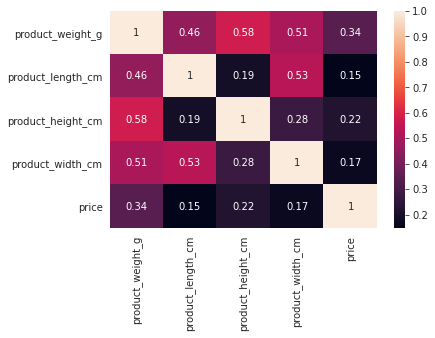

In [84]:
sns.heatmap(ord_pay[['product_weight_g','product_length_cm','product_height_cm','product_width_cm','price']].corr(),annot=True)
plt.show()

In [85]:
top_sellers = olist_order_items.groupby('product_id')['order_id'].count().nlargest().index

In [86]:
olist_products[olist_products['product_id'].isin(top_sellers)].merge(olist_products_translation,on='product_category_name')

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,368c6c730842d78016ad823897a372db,ferramentas_jardim,57.0,366.0,2.0,1650.0,30.0,22.0,30.0,garden_tools
1,422879e10f46682990de24d770e7f83d,ferramentas_jardim,56.0,348.0,2.0,1550.0,30.0,22.0,30.0,garden_tools
2,389d119b48cf3043d311335e499d9c6b,ferramentas_jardim,59.0,341.0,2.0,1750.0,37.0,22.0,40.0,garden_tools
3,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,bed_bath_table
4,aca2eb7d00ea1a7b8ebd4e68314663af,moveis_decoracao,44.0,903.0,6.0,2600.0,50.0,10.0,30.0,furniture_decor


In [87]:
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [88]:
olist_order_payments.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


# Convert the purchase data to sales data 

In [89]:
purchase_date = olist_orders[['order_id','order_purchase_timestamp']]

In [90]:
olist_order_date = olist_order_items.merge(purchase_date,on='order_id')

In [91]:
olist_order_date.describe()

,order_item_id,price,freight_value
count,112650.000000,112650.000000,112650.000000
mean,1.197834,120.653739,19.990320
std,0.705124,183.633928,15.806405
min,1.000000,0.850000,0.000000
25%,1.000000,39.900000,13.080000
50%,1.000000,74.990000,16.260000
75%,1.000000,134.900000,21.150000
max,21.000000,6735.000000,409.680000


In [92]:
olist_order_date.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112650 entries, 0 to 112649
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   order_id                  112650 non-null  object 
 1   order_item_id             112650 non-null  int64  
 2   product_id                112650 non-null  object 
 3   seller_id                 112650 non-null  object 
 4   shipping_limit_date       112650 non-null  object 
 5   price                     112650 non-null  float64
 6   freight_value             112650 non-null  float64
 7   order_purchase_timestamp  112650 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 7.7+ MB


In [93]:
olist_order_date['order_purchase_timestamp']=pd.to_datetime(olist_order_date['order_purchase_timestamp'])
olist_order_date['order_purchase_year'] = olist_order_date['order_purchase_timestamp'].dt.year
olist_order_date['order_purchase_month'] = olist_order_date['order_purchase_timestamp'].dt.month
olist_order_date['order_purchase_date'] = olist_order_date['order_purchase_timestamp'].dt.date
olist_order_date['order_purchase_day'] = olist_order_date['order_purchase_timestamp'].dt.day
olist_order_date['order_purchase_week'] = olist_order_date['order_purchase_timestamp'].dt.week
olist_order_date['order_purchase_hour'] = olist_order_date['order_purchase_timestamp'].dt.hour

In [94]:
olist_monthly_sales_data=olist_order_date.groupby(['order_purchase_month','product_id']).sum()['price']

### The sales of each products in each month

In [95]:
pd.DataFrame(olist_monthly_sales_data).sort_values('price',ascending=False)

,,price
order_purchase_month,product_id,
9,d6160fb7873f184099d9bc95e30376af,29899.39
3,25c38557cf793876c5abdd5931f922db,18713.70
6,fd0065af7f09af4b82a0ca8f3eed1852,17999.91
10,588531f8ec37e7d5ff5b7b22ea0488f8,17244.00
9,5769ef0a239114ac3a854af00df129e4,13440.00
...,...,...
2,2e8316b31db34314f393806fd7b6e185,2.99
1,680cc8535be7cc69544238c1d6a83fe8,2.90
4,8a3254bee785a526d548a81a9bc3c9be,2.55


In [96]:
product_mean_price = olist_order_items.merge(olist_order_items.groupby('product_id')['price'].mean(),on='product_id')

In [97]:
product_mean_price.drop(['order_item_id'],axis=1,inplace=True)

In [98]:
product_mean_price['price_difference'] = np.where(product_mean_price['price_x'].equals(product_mean_price['price_y'])
                     , 0, np.abs(product_mean_price['price_x']- product_mean_price['price_y']))

In [99]:
product_mean_price

,order_id,product_id,seller_id,shipping_limit_date,price_x,freight_value,price_y,price_difference
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,59.233333,0.333333
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,59.233333,3.333333
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,59.233333,5.666667
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-07 18:55:08,58.9,16.17,59.233333,0.333333
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-08-16 22:05:11,58.9,13.29,59.233333,0.333333
...,...,...,...,...,...,...,...,...
112645,ffebd80e3291e811c308365936897efd,4cc4d02efc8f249c13355147fb44e34d,d1c7fa84e48cfa21a0e595167c1c500e,2018-07-18 20:23:55,129.9,51.20,129.900000,0.000000
112646,ffee31fb4b5e35c9123608015637c495,b10ecf8e33aaaea419a9fa860ea80fb5,0241d4d5d36f10f80c644447315af0bd,2018-08-21 10:10:11,99.0,13.52,99.000000,0.000000
112647,fff7c4452f050315db1b3f24d9df5fcd,dd469c03ad67e201bc2179ef077dcd48,7e93a43ef30c4f03f38b393420bc753a,2017-06-07 17:05:23,736.0,20.91,736.000000,0.000000
112648,fffa82886406ccf10c7b4e35c4ff2788,bbe7651fef80287a816ead73f065fc4b,8f2ce03f928b567e3d56181ae20ae952,2017-12-22 17:31:42,229.9,44.02,229.900000,0.000000


### Products which are bought more than once

In [100]:
products_more_than_once = product_mean_price.product_id.value_counts().loc[lambda x: x>1].index

In [101]:
Best_selling_products = product_mean_price[product_mean_price['product_id'].isin(products_more_than_once)].sort_values(['product_id','price_difference'],ascending=False)

In [102]:
product_mean_price[['order_id','product_id','seller_id']].value_counts()

order_id                          product_id                        seller_id                       
ab14fdcfbe524636d65ee38360e22ce8  9571759451b1d780ee7c15012ea109d4  ce27a3cc3c8cc1ea79d11e561e9bebb6    20
1b15974a0141d54e36626dca3fdc731a  ee3d532c8a438679776d222e997606b3  8e6d7754bc7e0f22c96d255ebda59eba    20
428a2f660dc84138d969ccd69a0ab6d5  89b190a046022486c635022524a974a8  f326006815956455b2859abd58fe7e39    15
9ef13efd6949e4573a18964dd1bbe7f5  37eb69aca8718e843d897aa7b82f462d  0b36063d5818f81ccb94b54adfaebbf5    15
9bdc4d4c71aa1de4606060929dee888c  44a5d24dd383324a421569ca697b13c2  e7d5b006eb624f13074497221eb37807    14
                                                                                                        ..
a86a34972a168f819d4e6fbf8d07a264  82ed1009173f99aeacc5499e24e9a7a0  c3fe93ba3085f92855c97e57f38c8c05     1
a86ad6bfca543eb89c02ccd35b2d4099  7fab1a1472fdd934397068931f63f3ca  3d871de0142ce09b7081e2b9d1733cb1     1
a86beac32a9e23997ac3016ccbffe061  bea56a01c

In [103]:
product_mean_price.product_id.value_counts().loc[lambda x: x>1]

aca2eb7d00ea1a7b8ebd4e68314663af    527
99a4788cb24856965c36a24e339b6058    488
422879e10f46682990de24d770e7f83d    484
389d119b48cf3043d311335e499d9c6b    392
368c6c730842d78016ad823897a372db    388
                                   ... 
2d07cb5238b8e2ba12a4b2ac8b6f100a      2
9d82a263e18f0b5ede827b8dd9825e74      2
21f8d380f12105e9b35b919553d70380      2
edb58f769af494909a8851152c3a2d1d      2
9271d2541a43f8db13d164887228a189      2
Name: product_id, Length: 14834, dtype: int64

# Hypothesis generation

In [104]:
olist_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [105]:
olist_orders['order_purchase_timestamp'].apply(lambda x: x[:7]).value_counts()

2017-11    7544
2018-01    7269
2018-03    7211
2018-04    6939
2018-05    6873
2018-02    6728
2018-08    6512
2018-07    6292
2018-06    6167
2017-12    5673
2017-10    4631
2017-08    4331
2017-09    4285
2017-07    4026
2017-05    3700
2017-06    3245
2017-03    2682
2017-04    2404
2017-02    1780
2017-01     800
2016-10     324
2018-09      16
2016-09       4
2018-10       4
2016-12       1
Name: order_purchase_timestamp, dtype: int64

In [106]:
olist_order_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [107]:
olist_order_date.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_date,order_purchase_day,order_purchase_week,order_purchase_hour
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,2017,9,2017-09-13,13,37,8
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,2017,4,2017-04-26,26,17,10
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,2018,1,2018-01-14,14,2,14
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,2018,8,2018-08-08,8,32,10
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,2017,2,2017-02-04,4,5,13


In [108]:
olist_order_date['Month_Year'] = olist_order_date['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))

In [ ]:
olist_order_date.head(1)

,level_0,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_date,order_purchase_day,order_purchase_week,order_purchase_hour,Month_Year
0,0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,2017-09-13 08:59:02,2017,9,2017-09-13,13,37,8,2017-09


In [109]:
monthly_total_sales_per_prod = olist_order_date.groupby(['Month_Year','product_id']).sum()[['price','freight_value']]
monthly_total_sales_per_prod

price  freight_value
Month_Year product_id                                             
2016-09    5a6b04657a4c5ee34285d1e4619a96b4  134.97           8.49
           c1488892604e4ba5cff5b4eb4d595400   39.99          31.67
           f293394c72c9b5fafd7023301fc21fc2   32.90          31.67
           f3c2d01a84c947b078e32bbef0718962   59.50          15.56
2016-10    027cdd14a677a5834bc67a9789db5021   89.90          15.49
...                                             ...            ...
2018-08    ffc9caf33e2d1e9f44e3e06da19085f7  219.89          12.56
           ffd4bf4306745865e5692f69bd237893   29.99          22.93
           ffd9ac56db9194a413298faaa03cd176   89.00          23.77
           fffdb2d0ec8d6a61f0a0a0db3f25b441   69.98          15.02
2018-09    b98992ea80b467987a7fbb88e7f2076a  145.00          21.46

[62176 rows x 2 columns]

In [110]:
monthly_total_sales_per_prod = monthly_total_sales_per_prod.reset_index()
monthly_total_sales_per_prod

,Month_Year,product_id,price,freight_value
0,2016-09,5a6b04657a4c5ee34285d1e4619a96b4,134.97,8.49
1,2016-09,c1488892604e4ba5cff5b4eb4d595400,39.99,31.67
2,2016-09,f293394c72c9b5fafd7023301fc21fc2,32.90,31.67
3,2016-09,f3c2d01a84c947b078e32bbef0718962,59.50,15.56
4,2016-10,027cdd14a677a5834bc67a9789db5021,89.90,15.49
...,...,...,...,...
62171,2018-08,ffc9caf33e2d1e9f44e3e06da19085f7,219.89,12.56
62172,2018-08,ffd4bf4306745865e5692f69bd237893,29.99,22.93
62173,2018-08,ffd9ac56db9194a413298faaa03cd176,89.00,23.77
62174,2018-08,fffdb2d0ec8d6a61f0a0a0db3f25b441,69.98,15.02


In [118]:
monthly_total_sales_per_prod.product_id.nunique()

32951

In [120]:
monthly_total_sales_per_prod[monthly_total_sales_per_prod.Month_Year.apply(lambda x: x[:4] == '2017')]

,Month_Year,product_id,price,freight_value
279,2017-01,001c5d71ac6ad696d22315953758fa04,79.90,20.74
280,2017-01,00be617b58175bf207fd35910d5097a4,48.90,15.56
281,2017-01,010a3a47c14f1295796c08419f32cef6,9.99,50.00
282,2017-01,014a8a503291921f7b004a5215bb3c36,36.90,8.72
283,2017-01,01586bfbe1d5449887f1cac4ad1fbd02,12.97,10.96
...,...,...,...,...
29121,2017-12,ffc0b406806006602c5853b00ab5f7fd,69.90,18.38
29122,2017-12,ffce5ed9e0bcc2e46796b988cdac733b,399.00,11.61
29123,2017-12,ffcfaba393e8ef71937c6e8421bc2868,288.00,86.34
29124,2017-12,ffd34459c21034d1da6df9800de0d7a3,52.99,15.12


In [121]:
# removing 2016 data and taking out 2017 data to train and 2018 data for test
monthly_sales_per_prod_2017 = monthly_total_sales_per_prod[monthly_total_sales_per_prod.Month_Year.apply(lambda x: x[:4] == '2017')].reset_index()
monthly_sales_per_prod_2017

,index,Month_Year,product_id,price,freight_value
0,279,2017-01,001c5d71ac6ad696d22315953758fa04,79.90,20.74
1,280,2017-01,00be617b58175bf207fd35910d5097a4,48.90,15.56
2,281,2017-01,010a3a47c14f1295796c08419f32cef6,9.99,50.00
3,282,2017-01,014a8a503291921f7b004a5215bb3c36,36.90,8.72
4,283,2017-01,01586bfbe1d5449887f1cac4ad1fbd02,12.97,10.96
...,...,...,...,...,...
28842,29121,2017-12,ffc0b406806006602c5853b00ab5f7fd,69.90,18.38
28843,29122,2017-12,ffce5ed9e0bcc2e46796b988cdac733b,399.00,11.61
28844,29123,2017-12,ffcfaba393e8ef71937c6e8421bc2868,288.00,86.34
28845,29124,2017-12,ffd34459c21034d1da6df9800de0d7a3,52.99,15.12


In [122]:
monthly_total_sales_per_prod[monthly_total_sales_per_prod.Month_Year.apply(lambda x: (x[:7] >= '2017-01' and x[:7]<= '2018-07'))].reset_index()

,index,Month_Year,product_id,price,freight_value
0,279,2017-01,001c5d71ac6ad696d22315953758fa04,79.90,20.74
1,280,2017-01,00be617b58175bf207fd35910d5097a4,48.90,15.56
2,281,2017-01,010a3a47c14f1295796c08419f32cef6,9.99,50.00
3,282,2017-01,014a8a503291921f7b004a5215bb3c36,36.90,8.72
4,283,2017-01,01586bfbe1d5449887f1cac4ad1fbd02,12.97,10.96
...,...,...,...,...,...
57522,57801,2018-07,ffc88104d219c1b767d566fd93653dd2,39.90,9.03
57523,57802,2018-07,ffedbd68fa6f44e788ff6c2db8094715,200.00,102.46
57524,57803,2018-07,ffef256879dbadcab7e77950f4f4a195,63.56,31.20
57525,57804,2018-07,fff515ea94dbf35d54d256b3e39f0fea,818.00,20.83


In [123]:
monthly_sales_per_prod_2018 = monthly_total_sales_per_prod[monthly_total_sales_per_prod.Month_Year.apply(lambda x: x[:4] == '2018')].reset_index()
monthly_sales_per_prod_2018

,index,Month_Year,product_id,price,freight_value
0,29126,2018-01,002959d7a0b0990fe2d69988affcbc80,129.90,98.02
1,29127,2018-01,0043c62d00db47eff6a6bc4cf6bfaeda,527.99,20.14
2,29128,2018-01,005030ef108f58b46b78116f754d8d38,13.99,7.78
3,29129,2018-01,005c6b24cc96dca3e2c01e824401030e,43.50,15.10
4,29130,2018-01,006baa9a5b8f95895f15273a35bc2664,99.90,13.25
...,...,...,...,...,...
33045,62171,2018-08,ffc9caf33e2d1e9f44e3e06da19085f7,219.89,12.56
33046,62172,2018-08,ffd4bf4306745865e5692f69bd237893,29.99,22.93
33047,62173,2018-08,ffd9ac56db9194a413298faaa03cd176,89.00,23.77
33048,62174,2018-08,fffdb2d0ec8d6a61f0a0a0db3f25b441,69.98,15.02


In [124]:
monthly_sales_per_prod_2017.product_id.nunique(),monthly_sales_per_prod_2018.product_id.nunique()

(17273, 20495)

- There are 32,951 unique products in the sales data above created
- There are 17,273 unique products bought in the year 2017 
- There are 20,495 unique products bought in the year 2018
- Clearly, there are some new products which is brought in the year 2018.

In [125]:
monthly_sales_per_prod_2017.sort_values(['Month_Year','product_id'],ascending=True)

,index,Month_Year,product_id,price,freight_value
0,279,2017-01,001c5d71ac6ad696d22315953758fa04,79.90,20.74
1,280,2017-01,00be617b58175bf207fd35910d5097a4,48.90,15.56
2,281,2017-01,010a3a47c14f1295796c08419f32cef6,9.99,50.00
3,282,2017-01,014a8a503291921f7b004a5215bb3c36,36.90,8.72
4,283,2017-01,01586bfbe1d5449887f1cac4ad1fbd02,12.97,10.96
...,...,...,...,...,...
28842,29121,2017-12,ffc0b406806006602c5853b00ab5f7fd,69.90,18.38
28843,29122,2017-12,ffce5ed9e0bcc2e46796b988cdac733b,399.00,11.61
28844,29123,2017-12,ffcfaba393e8ef71937c6e8421bc2868,288.00,86.34
28845,29124,2017-12,ffd34459c21034d1da6df9800de0d7a3,52.99,15.12


In [126]:
pd.crosstab(olist_order_date['order_purchase_year'],olist_order_date['order_purchase_month']).sort_index(1)

order_purchase_month,1,2,3,4,5,6,7,8,9,10,11,12
order_purchase_year,,,,,,,,,,,,
2016,0,0,0,0,0,0,0,0,6,363,0,1
2017,955,1951,3000,2684,4136,3583,4519,4910,4831,5322,8665,6308
2018,8208,7672,8217,7975,7925,7078,7092,7248,1,0,0,0


In [127]:
# removing 2018-09 as it has only one record.
olist_order_date = olist_order_date.drop(olist_order_date[olist_order_date['Month_Year'] == '2018-09'].index).reset_index(drop=True)
pd.crosstab(olist_order_date['order_purchase_year'],olist_order_date['order_purchase_month']).sort_index(1)

order_purchase_month,1,2,3,4,5,6,7,8,9,10,11,12
order_purchase_year,,,,,,,,,,,,
2016,0,0,0,0,0,0,0,0,6,363,0,1
2017,955,1951,3000,2684,4136,3583,4519,4910,4831,5322,8665,6308
2018,8208,7672,8217,7975,7925,7078,7092,7248,0,0,0,0


In [128]:
# There is only 1 order in the month year - 2016-12 with total sales 10.90. Hence removing year 2016.
olist_order_date = olist_order_date.drop(olist_order_date[olist_order_date['Month_Year'].apply(lambda x: x[:4] == '2016')].index).reset_index(drop=True)
pd.crosstab(olist_order_date['order_purchase_year'],olist_order_date['order_purchase_month']).sort_index(1)

order_purchase_month,1,2,3,4,5,6,7,8,9,10,11,12
order_purchase_year,,,,,,,,,,,,
2017,955,1951,3000,2684,4136,3583,4519,4910,4831,5322,8665,6308
2018,8208,7672,8217,7975,7925,7078,7092,7248,0,0,0,0


In [129]:
products_in_2017 = monthly_sales_per_prod_2017.product_id.unique()
olist_2018_remvd_prod = olist_order_date[olist_order_date.product_id.isin(products_in_2017)]
olist_2018_remvd_prod.product_id.nunique()

17273

In [130]:
pd.crosstab(olist_2018_remvd_prod['order_purchase_year'],olist_2018_remvd_prod['order_purchase_month']).sort_index(1)

order_purchase_month,1,2,3,4,5,6,7,8,9,10,11,12
order_purchase_year,,,,,,,,,,,,
2017,955,1951,3000,2684,4136,3583,4519,4910,4831,5322,8665,6308
2018,5460,4394,4470,3557,3108,2362,2157,1922,0,0,0,0


In [131]:
products_in_2018 = monthly_sales_per_prod_2018.product_id.unique()
olist_2018_new_prod = olist_order_date[olist_order_date.product_id.isin(products_in_2018)]
olist_2018_new_prod.product_id.nunique()

20495

In [132]:
pd.crosstab(olist_2018_new_prod['order_purchase_year'],olist_2018_new_prod['order_purchase_month']).sort_index(1)

order_purchase_month,1,2,3,4,5,6,7,8,9,10,11,12
order_purchase_year,,,,,,,,,,,,
2017,249,577,998,983,1562,1597,2140,2263,2517,3051,5371,4366
2018,8208,7672,8217,7975,7925,7078,7092,7248,0,0,0,0


In [177]:
olist_order_date.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_date,order_purchase_day,order_purchase_week,order_purchase_hour,Month_Year
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,2017,9,2017-09-13,13,37,8,2017-09
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,2017,4,2017-04-26,26,17,10,2017-04
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,2018,1,2018-01-14,14,2,14,2018-01
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,2018,8,2018-08-08,8,32,10,2018-08
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,2017,2,2017-02-04,4,5,13,2017-02


### 1. What is the overall sales trend?

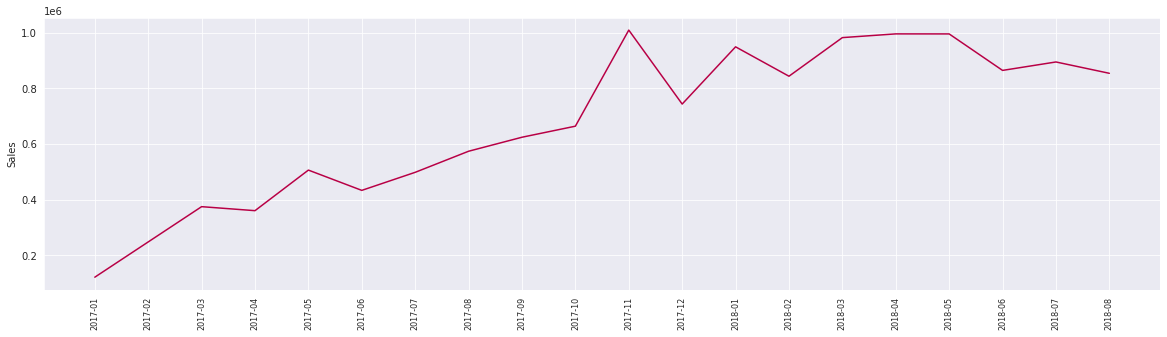

In [134]:
results = olist_order_date.groupby('Month_Year').sum()
months = [month for month, df in olist_order_date.groupby('Month_Year')]
plt.figure(figsize=(20,5))
plt.xticks(ticks = range(len(months)) ,labels = months, rotation='vertical', size = 8)
plt.ylabel('Sales')
plt.plot(months,results['price'], color = '#b80045')
plt.show()

- It is understood that there is increase in trend in the series. ie. Total sales is increasing with time.
- At certain points there is sudden increase in the monthly sales, the reason could be on a particular month, due to some event, the sales was high.

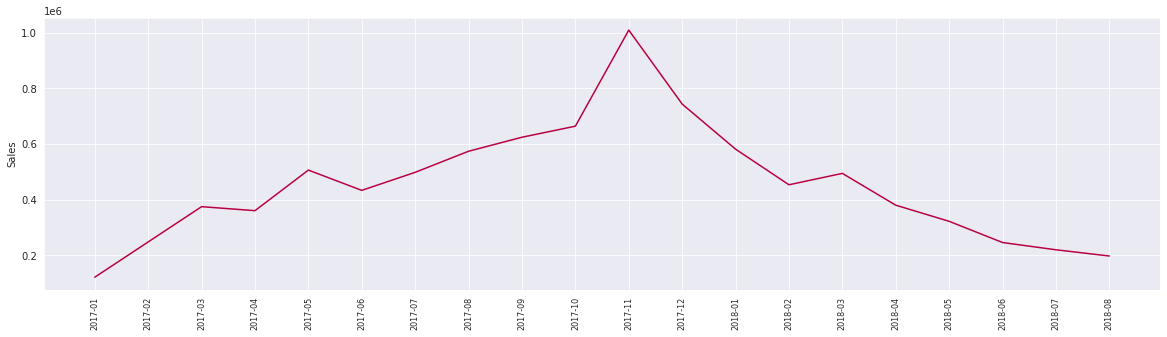

In [135]:
results1 = olist_2018_remvd_prod.groupby('Month_Year').sum()
months1 = [month for month, df in olist_2018_remvd_prod.groupby('Month_Year')]
plt.figure(figsize=(20,5))
plt.xticks(ticks = range(len(months1)) ,labels = months1, rotation='vertical', size = 8)
plt.ylabel('Sales')
plt.plot(months1,results1['price'], color = '#b80045')
plt.show()

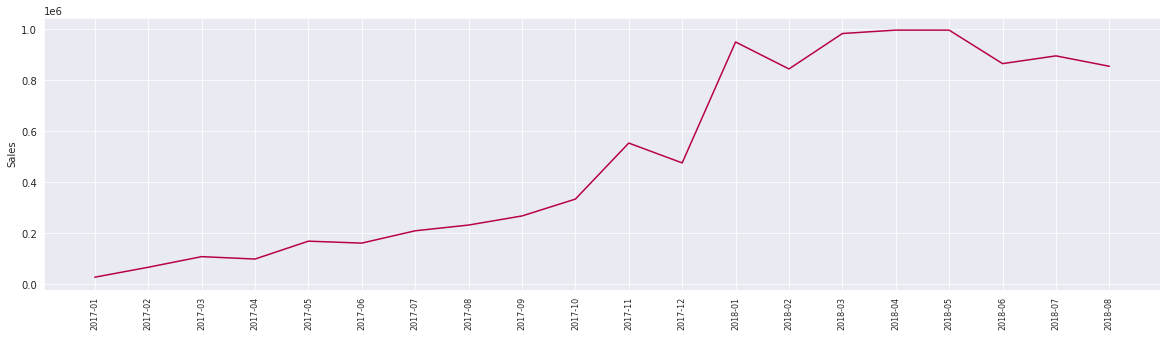

In [136]:
results1 = olist_2018_new_prod.groupby('Month_Year').sum()
months1 = [month for month, df in olist_2018_new_prod.groupby('Month_Year')]
plt.figure(figsize=(20,5))
plt.xticks(ticks = range(len(months1)) ,labels = months1, rotation='vertical', size = 8)
plt.ylabel('Sales')
plt.plot(months1,results1['price'], color = '#b80045')
plt.show()

### 2. What is MoM? (Month over month)


In [ ]:
MoM_Data = pd.DataFrame(results['price'])
MoM_Data.columns = ['Sales']
MoM_Data.head()

,Sales
Month_Year,
2017-01,120312.87
2017-02,247303.02
2017-03,374344.30
2017-04,359927.23
2017-05,506071.14


In [ ]:
MoM_Data['Last_Month'] = np.roll(MoM_Data['Sales'],1)
MoM_Data.head()

,Sales,Last_Month
Month_Year,,
2017-01,120312.87,854686.33
2017-02,247303.02,120312.87
2017-03,374344.30,247303.02
2017-04,359927.23,374344.30
2017-05,506071.14,359927.23


In [ ]:
#Now, since the MoM first month cannot be found since we donot have it's previous month value.
#By default, python has put the last value in the column and rolled up over there. SO we need to remove that.
MoM_Data = MoM_Data.drop(MoM_Data.index[0])
MoM_Data.head()

,Sales,Last_Month
Month_Year,,
2017-02,247303.02,120312.87
2017-03,374344.30,247303.02
2017-04,359927.23,374344.30
2017-05,506071.14,359927.23
2017-06,433038.60,506071.14


In [ ]:
#Calculating MoM Growth for each month
MoM_Data['Growth'] = (MoM_Data['Sales']/MoM_Data['Last_Month'])-1
MoM_Data.head()

,Sales,Last_Month,Growth
Month_Year,,,
2017-02,247303.02,120312.87,1.055499
2017-03,374344.30,247303.02,0.513707
2017-04,359927.23,374344.30,-0.038513
2017-05,506071.14,359927.23,0.406037
2017-06,433038.60,506071.14,-0.144313


In [ ]:
##Plotting MoM Growth
MoM_plot = MoM_Data.drop(columns = ["Sales", "Last_Month"])
MoM_plot['Months'] = MoM_plot.index
MoM_plot.reset_index(drop=True, inplace=True)
MoM_plot.head()

,Growth,Months
0,1.055499,2017-02
1,0.513707,2017-03
2,-0.038513,2017-04
3,0.406037,2017-05
4,-0.144313,2017-06


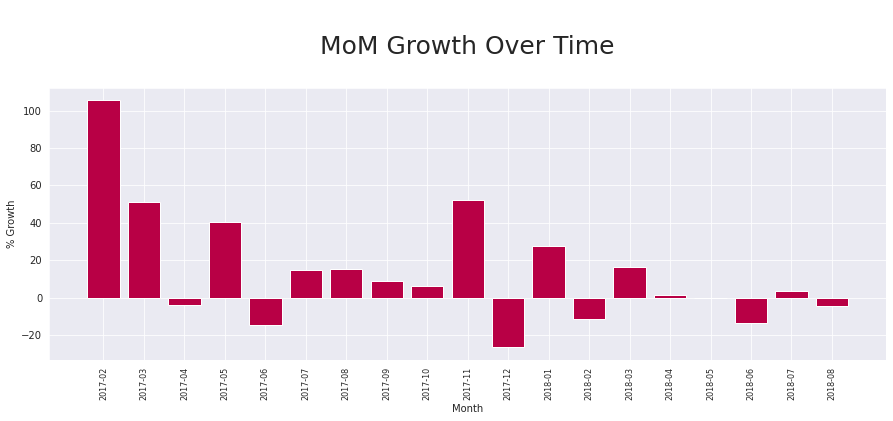

In [ ]:
plt.figure(figsize=(15,5))
plt.bar(MoM_plot['Months'],MoM_plot['Growth']*100, color = '#b80045')
plt.xticks(MoM_plot['Months'], rotation='vertical', size = 8)
plt.ylabel('% Growth')
plt.xlabel('Month')
plt.title("\n MoM Growth Over Time \n", size=25)
plt.show()

### 3. Which are the Top 10 products by sales?

In [ ]:
olist_prod = olist_products.merge(olist_products_translation,on='product_category_name').drop('product_category_name',1)

In [ ]:
olist_prod.head()

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery
1,6a2fb4dd53d2cdb88e0432f1284a004c,39.0,346.0,2.0,400.0,27.0,5.0,20.0,perfumery
2,0d009643171aee696f4733340bc2fdd0,52.0,150.0,1.0,422.0,21.0,16.0,18.0,perfumery
3,b1eae565a61935e0011ee7682fef9dc9,49.0,460.0,2.0,267.0,17.0,13.0,17.0,perfumery
4,8da90b37f0fb171b4877c124f965b1f6,56.0,733.0,3.0,377.0,18.0,13.0,15.0,perfumery


In [ ]:
prod_sales = pd.DataFrame(olist_order_date.groupby('product_id').sum()['price'])
prod_sales.sort_values(by=['price'], inplace=True, ascending=False)

#Calculating Top 10:
top_prods = prod_sales.head(10)
top_prods.reset_index().merge(olist_prod,on='product_id')[['product_id','price','product_category_name_english']]


,product_id,price,product_category_name_english
0,bb50f2e236e5eea0100680137654686c,63885.00,health_beauty
1,6cdd53843498f92890544667809f1595,54730.20,health_beauty
2,d6160fb7873f184099d9bc95e30376af,48899.34,computers
3,d1c427060a0f73f6b889a5c7c61f2ac4,47214.51,computers_accessories
4,99a4788cb24856965c36a24e339b6058,43025.56,bed_bath_table
5,3dd2a17168ec895c781a9191c1e95ad7,41082.60,computers_accessories
6,25c38557cf793876c5abdd5931f922db,38907.32,baby
7,5f504b3a1c75b73d6151be81eb05bdc9,37733.90,cool_stuff
8,53b36df67ebb7c41585e8d54d6772e08,37683.42,watches_gifts
9,aca2eb7d00ea1a7b8ebd4e68314663af,37608.90,furniture_decor


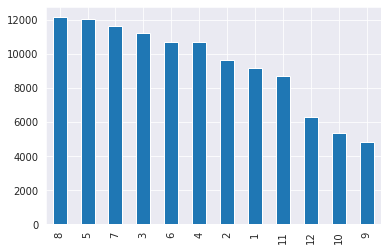

In [ ]:
olist_order_date['order_purchase_month'].value_counts().plot(kind='bar');

- Overall sales on the months of 2017 and 2018 says, Sales is more in the months of August and may.


In [ ]:
olist_order_date

,level_0,index,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,order_purchase_timestamp,order_purchase_year,order_purchase_month,order_purchase_date,order_purchase_day,order_purchase_week,order_purchase_hour,Month_Year
0,0,0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,2017-09-13 08:59:02,2017,9,2017-09-13,13,37,8,2017-09
1,1,1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,2017-04-26 10:53:06,2017,4,2017-04-26,26,17,10,2017-04
2,2,2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,2018-01-14 14:33:31,2018,1,2018-01-14,14,2,14,2018-01
3,3,3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,2018-08-08 10:00:35,2018,8,2018-08-08,8,32,10,2018-08
4,4,4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,2017-02-04 13:57:51,2017,2,2017-02-04,4,5,13,2017-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112274,112644,112645,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,2018-05-02 04:11:01,299.99,43.41,2018-04-23 13:57:06,2018,4,2018-04-23,23,17,13,2018-04
112275,112645,112646,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,2018-07-20 04:31:48,350.00,36.53,2018-07-14 10:26:46,2018,7,2018-07-14,14,28,10,2018-07
112276,112646,112647,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,2017-10-30 17:14:25,99.90,16.95,2017-10-23 17:07:56,2017,10,2017-10-23,23,43,17,2017-10
112277,112647,112648,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,2017-08-21 00:04:32,55.99,8.72,2017-08-14 23:02:59,2017,8,2017-08-14,14,33,23,2017-08


In [ ]:
cols = ['customer_unique_id','order_id','order_item_id','order_purchase_timestamp','product_id','price','freight_value','product_category_name_english','customer_city','customer_state']
ord_pay[cols]

,customer_unique_id,order_id,order_item_id,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english,customer_city,customer_state
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,1,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,housewares,sao paulo,SP
1,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,1,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,housewares,sao paulo,SP
2,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,1,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,housewares,sao paulo,SP
3,3a51803cc0d012c3b5dc8b7528cb05f7,128e10d95713541c87cd1a2e48201934,1,2017-08-15 18:29:31,87285b34884572647811a353c7ac498a,29.99,7.78,housewares,sao paulo,SP
4,ef0996a1a279c26e7ecbd737be23d235,0e7e841ddf8f8f2de2bad69267ecfbcf,1,2017-08-02 18:24:47,87285b34884572647811a353c7ac498a,29.99,7.78,housewares,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...
115873,c5da6424f1f5decedef8672a1a0103e1,edcf1e1eeb52381be9388c90152be52d,1,2018-08-21 11:29:05,6bb18295cc019bf3b6dc7c773411d530,289.49,24.83,arts_and_craftmanship,brusque,SC
115874,8c3c961a52bb5a0ffbce1d4e6d25cd67,2c12150c742ae2fa48bc703964c16c5f,1,2018-07-28 17:55:27,2b54fb9a4acf707537eb53eb2458c241,57.90,19.60,arts_and_craftmanship,joao monlevade,MG
115875,428f4721a509be8c52de6ec2900ba918,9f7ba492c273ffac8f90a623b8eadd3b,1,2018-08-23 12:31:37,5aa0d6ed4e6c0995d62090cd82cde89a,11.90,12.79,arts_and_craftmanship,jacarei,SP
115876,8d80e477643ec569b24592ce3d9dfc4c,2ef4a11b6e24fdfbb43b92cb5f95edff,1,2018-07-23 18:35:14,9c313adb4b38a55b092f53f83f78be9e,19.00,12.86,arts_and_craftmanship,diadema,SP


In [ ]:
cust_order = ord_pay[cols].drop_duplicates(subset =['order_id','order_item_id','product_id'])
cust_order 

,customer_unique_id,order_id,order_item_id,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english,customer_city,customer_state
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,1,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,housewares,sao paulo,SP
3,3a51803cc0d012c3b5dc8b7528cb05f7,128e10d95713541c87cd1a2e48201934,1,2017-08-15 18:29:31,87285b34884572647811a353c7ac498a,29.99,7.78,housewares,sao paulo,SP
4,ef0996a1a279c26e7ecbd737be23d235,0e7e841ddf8f8f2de2bad69267ecfbcf,1,2017-08-02 18:24:47,87285b34884572647811a353c7ac498a,29.99,7.78,housewares,sao paulo,SP
5,e781fdcc107d13d865fc7698711cc572,bfc39df4f36c3693ff3b63fcbea9e90a,1,2017-10-23 23:26:46,87285b34884572647811a353c7ac498a,29.99,14.10,housewares,florianopolis,SC
6,7a1de9bde89aedca8c5fbad489c5571c,5f49f31e537f8f1a496454b48edbe34d,2,2017-08-24 11:31:28,be03d93320192443b8fa24c0ca6ead98,46.80,67.70,housewares,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...
115873,c5da6424f1f5decedef8672a1a0103e1,edcf1e1eeb52381be9388c90152be52d,1,2018-08-21 11:29:05,6bb18295cc019bf3b6dc7c773411d530,289.49,24.83,arts_and_craftmanship,brusque,SC
115874,8c3c961a52bb5a0ffbce1d4e6d25cd67,2c12150c742ae2fa48bc703964c16c5f,1,2018-07-28 17:55:27,2b54fb9a4acf707537eb53eb2458c241,57.90,19.60,arts_and_craftmanship,joao monlevade,MG
115875,428f4721a509be8c52de6ec2900ba918,9f7ba492c273ffac8f90a623b8eadd3b,1,2018-08-23 12:31:37,5aa0d6ed4e6c0995d62090cd82cde89a,11.90,12.79,arts_and_craftmanship,jacarei,SP
115876,8d80e477643ec569b24592ce3d9dfc4c,2ef4a11b6e24fdfbb43b92cb5f95edff,1,2018-07-23 18:35:14,9c313adb4b38a55b092f53f83f78be9e,19.00,12.86,arts_and_craftmanship,diadema,SP


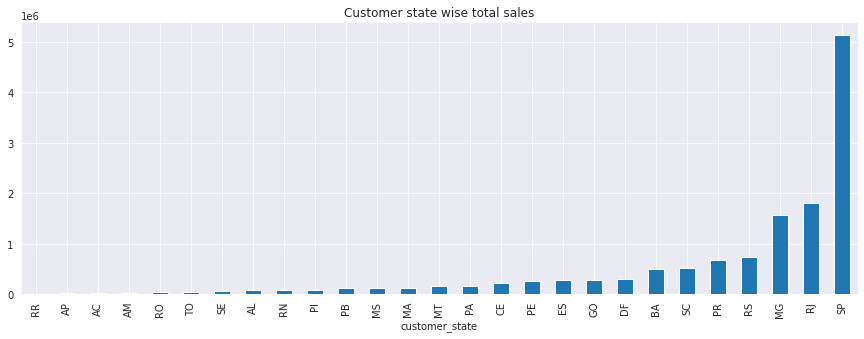

In [ ]:
plt.figure(figsize=(15,5))
plt.title('Customer state wise total sales')
cust_order.groupby('customer_state')['price'].sum().sort_values().plot(kind='bar');

In [ ]:
cust_order['Month_Year'] = cust_order['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))
cust_order

,customer_unique_id,order_id,order_item_id,order_purchase_timestamp,product_id,price,freight_value,product_category_name_english,customer_city,customer_state,Month_Year
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,1,2017-10-02 10:56:33,87285b34884572647811a353c7ac498a,29.99,8.72,housewares,sao paulo,SP,2017-10
3,3a51803cc0d012c3b5dc8b7528cb05f7,128e10d95713541c87cd1a2e48201934,1,2017-08-15 18:29:31,87285b34884572647811a353c7ac498a,29.99,7.78,housewares,sao paulo,SP,2017-08
4,ef0996a1a279c26e7ecbd737be23d235,0e7e841ddf8f8f2de2bad69267ecfbcf,1,2017-08-02 18:24:47,87285b34884572647811a353c7ac498a,29.99,7.78,housewares,sao paulo,SP,2017-08
5,e781fdcc107d13d865fc7698711cc572,bfc39df4f36c3693ff3b63fcbea9e90a,1,2017-10-23 23:26:46,87285b34884572647811a353c7ac498a,29.99,14.10,housewares,florianopolis,SC,2017-10
6,7a1de9bde89aedca8c5fbad489c5571c,5f49f31e537f8f1a496454b48edbe34d,2,2017-08-24 11:31:28,be03d93320192443b8fa24c0ca6ead98,46.80,67.70,housewares,sao paulo,SP,2017-08
...,...,...,...,...,...,...,...,...,...,...,...
115873,c5da6424f1f5decedef8672a1a0103e1,edcf1e1eeb52381be9388c90152be52d,1,2018-08-21 11:29:05,6bb18295cc019bf3b6dc7c773411d530,289.49,24.83,arts_and_craftmanship,brusque,SC,2018-08
115874,8c3c961a52bb5a0ffbce1d4e6d25cd67,2c12150c742ae2fa48bc703964c16c5f,1,2018-07-28 17:55:27,2b54fb9a4acf707537eb53eb2458c241,57.90,19.60,arts_and_craftmanship,joao monlevade,MG,2018-07
115875,428f4721a509be8c52de6ec2900ba918,9f7ba492c273ffac8f90a623b8eadd3b,1,2018-08-23 12:31:37,5aa0d6ed4e6c0995d62090cd82cde89a,11.90,12.79,arts_and_craftmanship,jacarei,SP,2018-08
115876,8d80e477643ec569b24592ce3d9dfc4c,2ef4a11b6e24fdfbb43b92cb5f95edff,1,2018-07-23 18:35:14,9c313adb4b38a55b092f53f83f78be9e,19.00,12.86,arts_and_craftmanship,diadema,SP,2018-07


In [ ]:
Top_states_high_sales = pd.pivot_table(cust_order,index='customer_state',columns=['Month_Year'],values='price',aggfunc='sum').drop(['2016-09','2016-10','2016-12','2018-09'],1).loc[['SP','RJ','MG']]

In [ ]:
Top_states_high_sales

Month_Year,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,2018-05,2018-06,2018-07,2018-08
customer_state,,,,,,,,,,,,,,,,,,,,
SP,40617.31,76290.85,133773.40,129350.33,174859.82,171823.29,182912.19,196770.24,215963.44,219915.77,356133.76,274174.48,364947.35,308518.07,380152.74,395619.37,435768.22,342896.24,323743.06,395181.39
RJ,12593.20,31615.76,55301.93,56738.37,71870.15,52921.12,78282.30,77870.88,94585.28,95853.94,147484.69,114025.59,120430.03,116390.82,116918.65,122302.62,126625.00,102798.57,98925.53,95083.20
MG,16072.69,28615.75,41546.90,40144.92,49623.47,46561.33,54430.35,59090.30,72063.82,80072.97,132861.90,91748.01,113126.39,105625.51,118182.33,110587.93,103181.20,105940.84,97456.01,94065.96
